In [1]:
import cv2

In [2]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import gzip,pickle,sys
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
#from keras import backend as K
import PIL
import numpy as np
import random
import matplotlib.pyplot as plt
from random import randint
import os
import shutil
import pandas as pd
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
import itertools

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1146123532083109919,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3048682292
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12952279457783201491
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
batch_size = 32
img_height = 100
img_width = 100
mg_channels = 1
data_dir = './dataset/train'
labels = os.listdir(data_dir)

In [6]:
print(labels)
print(len(labels))

['Car', 'Truck']
2


In [7]:
#splitting the dataset

# import splitfolders
# splitfolders.ratio(data_dir, output="Data Split", seed=1337, ratio=(0.7, 0.2, 0.1))

In [8]:
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
                resized_arr = cv2.resize(img_arr, (img_height, img_width)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [9]:
train = get_data('./dataset/train')

In [10]:
val = get_data('./dataset/valid')

In [11]:
# test = get_data('./Data Split/test')

In [12]:
print(train.shape)
# print(test.shape)
print(val.shape)

(5117, 2)
(5051, 2)


Image label: 0


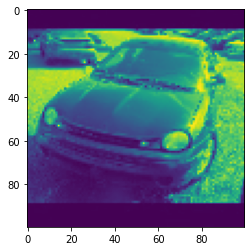

In [13]:
x_train = []
y_train = []
x_val = []
y_val = []
# x_test = []
# y_test = []
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# for feature, label in test:
#     x_test.append(feature)
#     y_test.append(label)


# Normalize the data
x_train = np.array(x_train)
x_val = np.array(x_val)
# x_test = np.array(x_test)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
# x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
# x_test /= 255

x_train.reshape(-1, img_height, img_width, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_height, img_width, 1)
y_val = np.array(y_val)

# x_test.reshape(-1, img_height, img_width, 1)
# y_test = np.array(y_test)

plt.imshow(x_val[9])
print("Image label: "+str(y_val[9]))

In [14]:
x_val, x_test, y_val, y_test= train_test_split(x_val, y_val, test_size=0.5) 

In [15]:
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5117, 100, 100)
x_val shape: (2525, 100, 100)
x_test shape: (2526, 100, 100)
5117 train samples
2525 validation samples
2526 test samples


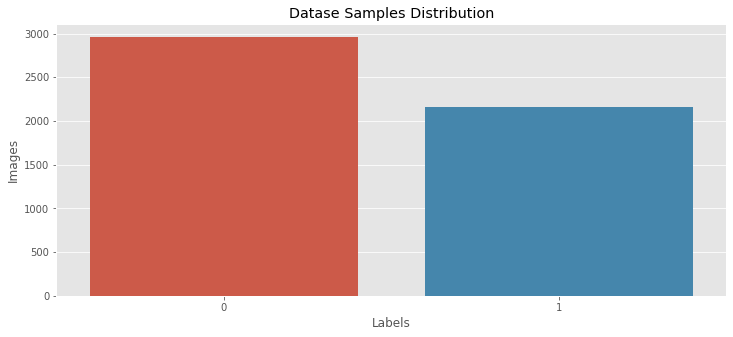

In [16]:
import seaborn as sns

plt.style.use("ggplot")
plt.figure(figsize=(12,5))
plt.title("Datase Samples Distribution")
sns.countplot(x = y_train)
plt.xlabel('Labels')
plt.ylabel('Images')
plt.show()

In [17]:
# a = np.arange(0,1000,1)
# #taking thousand random samples
# b = np.random.choice(Y_train, size=1000, replace=False)

# #print(a, b)

# for x, y in zip(a, b):
#     rgb = np.random.rand(3,)
#     plt.scatter(x, y, c=[rgb])
# plt.title("Dataset III Samples Distribution")
# plt.show()

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [19]:
earlystopper = EarlyStopping(patience=10, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=True,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

C:\Users\rafir\anaconda3\envs\Rafi\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [22]:
x_train = x_train.reshape(-1, img_height, img_width, 1)
x_val = x_val.reshape(-1, img_height, img_width, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)

In [23]:
datagen.fit(x_train)

In [24]:
num_classes = len(labels)
img_channels = 1

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', 
                 activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 input_shape=(img_height, img_width, 1)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same',  activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Conv2D(256, (3, 3),padding='same',  activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#save model to disk
model_json=model.to_json()
with open ("model.json","w") as json_file:
    json_file.write(model_json)
    print("Model Saved")

Model Saved


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0

In [26]:
#using Sparse Categorical Crossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
#using augmentation

epochs = 100

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val), callbacks = [MetricsCheckpoint('logs'), earlystopper,learning_rate_reduction])
print(history)
model.save_weights("modelWeight.h5")
score = model.evaluate(x_test, y_test, verbose=0)

print(' Training Complete ')
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Epoch 1/100
160/160 [==============================] - 33s 177ms/step - loss: 0.7085 - accuracy: 0.5572 - val_loss: 0.6810 - val_accuracy: 0.5782
Epoch 2/100
160/160 [==============================] - 25s 158ms/step - loss: 0.6846 - accuracy: 0.5721 - val_loss: 0.6815 - val_accuracy: 0.5782
Epoch 3/100
160/160 [==============================] - 25s 158ms/step - loss: 0.6835 - accuracy: 0.5754 - val_loss: 0.6809 - val_accuracy: 0.5782
Epoch 4/100
160/160 [==============================] - 25s 158ms/step - loss: 0.6814 - accuracy: 0.5791 - val_loss: 0.6811 - val_accuracy: 0.5782
Epoch 5/100
160/160 [==============================] - 25s 158ms/step - loss: 0.6799 - accuracy: 0.5845 - val_loss: 0.6812 - val_accuracy: 0.5782
Epoch 6/100
160/160 [==============================] - 25s 158ms/step - loss: 0.6809 - accuracy: 0.5802 - val_loss: 0.6809 - val_accuracy: 0.5782

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
160/160 [======================

In [39]:
range(earlystopper.stopped_epoch)

range(0, 71)

In [40]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='Validation Accuracy' if 'val' in k else 'Training Accuracy')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')

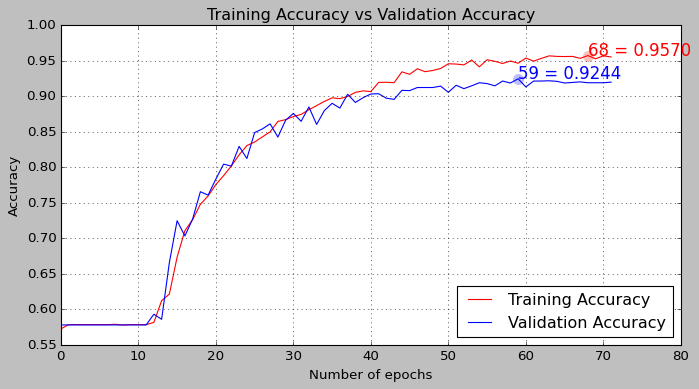

In [41]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis=1) 
y_true = np.argmax(y_test,axis=0)
plotKerasLearningCurve()
plt.show() 

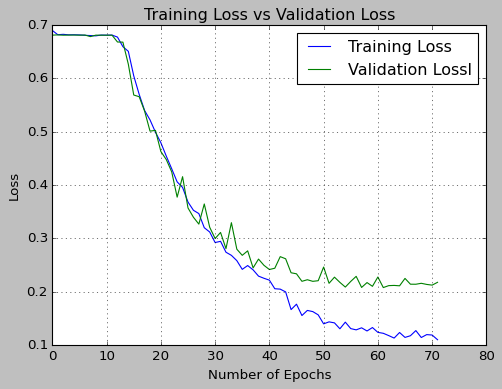

In [42]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

xc=range(earlystopper.stopped_epoch+1)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.grid(True)
plt.legend(['Training Loss','Validation Lossl'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [43]:
model_json=model.to_json()
with open ("model.json","w") as json_file:
    json_file.write(model_json)
    print("Model Saved")

Model Saved


In [44]:

#load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
#load weights into new model
loaded_model.load_weights("modelWeight.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 93.03%


In [45]:
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis=1) 
y_true = y_test

In [46]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
print('Confusion Matrix\n')
print(confusion_mtx)

Confusion Matrix

[[1410   52]
 [ 124  940]]


In [47]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true, y_pred_classes, target_names=labels))



Classification Report

              precision    recall  f1-score   support

         Car       0.92      0.96      0.94      1462
       Truck       0.95      0.88      0.91      1064

    accuracy                           0.93      2526
   macro avg       0.93      0.92      0.93      2526
weighted avg       0.93      0.93      0.93      2526



In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (25,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

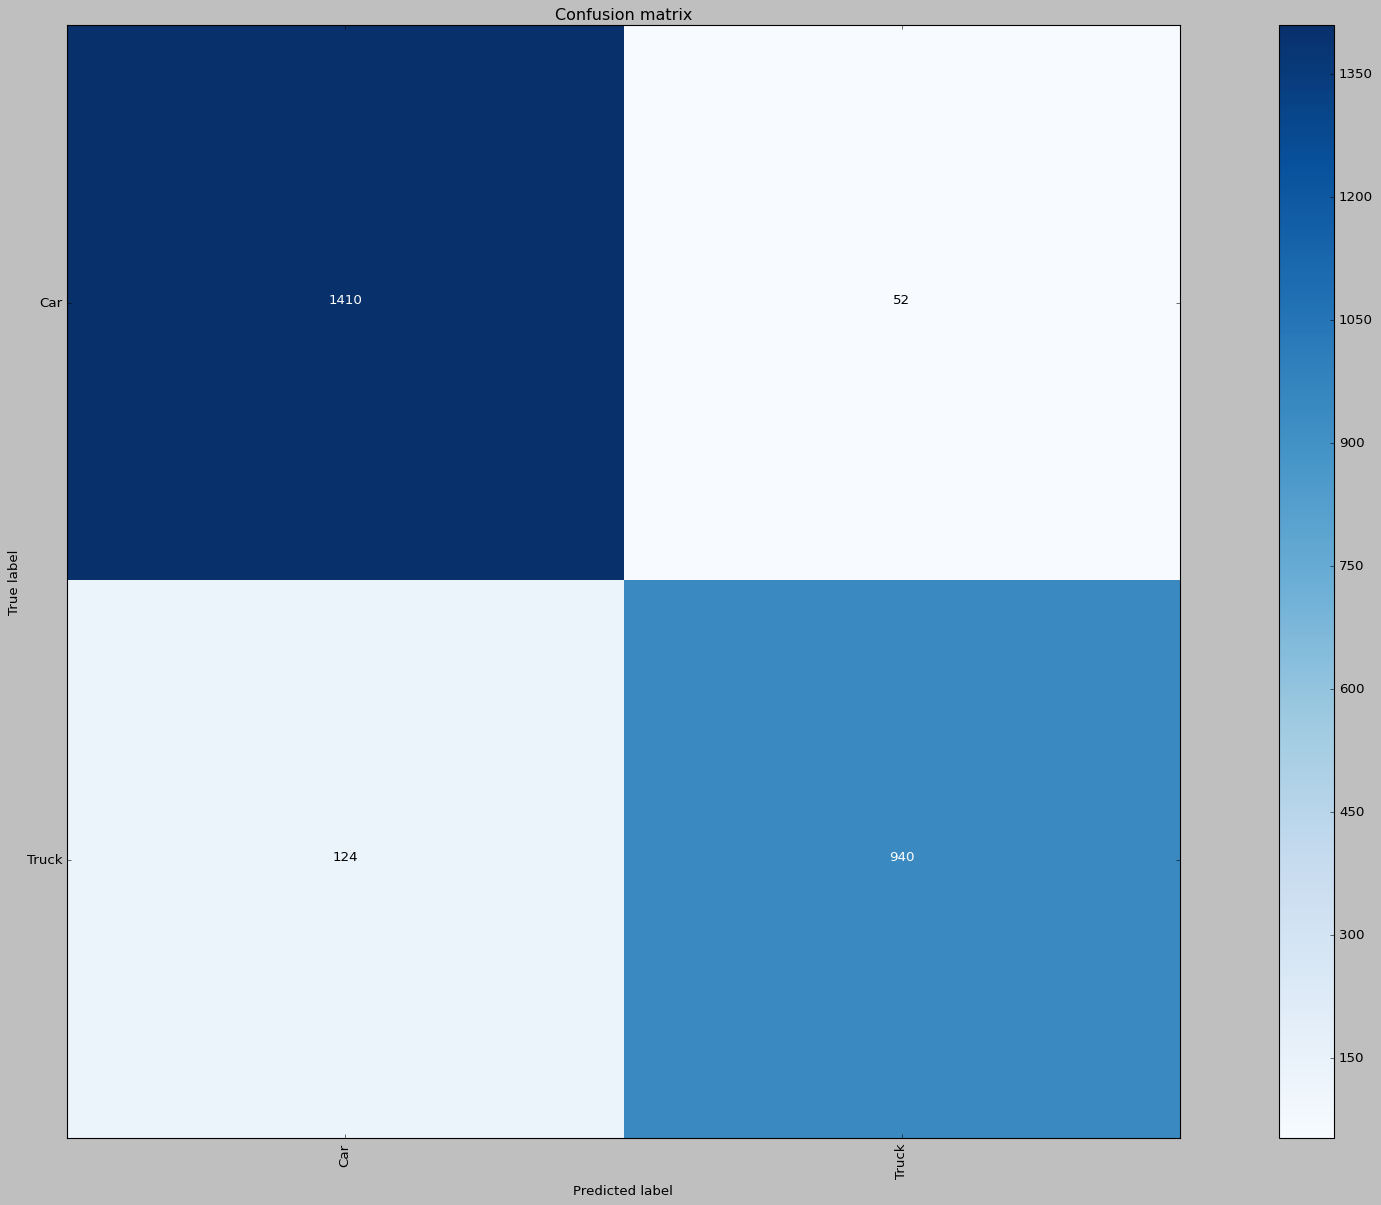

In [49]:
classes=labels
len(classes)
plot_confusion_matrix(confusion_mtx, classes)
plt.show()